# Decadal varibaility
This notebook is for plotting:

- **Figure 7**: Relative cumulative anomalies
- **Figure 10**: P-values for once-in-10-year or less winter Energy Drought Windows
- **Supplementary Figure 8**: Heatmaps showing statistically significant decadal variability across regions and energy sources
- **Supplementary Figure 9**: Future  Relative cumulative anomalies

requires running select_EDWs.py first

In [ ]:
# Core libraries
import glob
import numpy as np
import pandas as pd
import xarray as xr

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

# Other utilities
from sklearn.utils import resample

In [2]:
def get_events(ds,df):
    selected_data = []
    # Iterate through each row in the DataFrame to access the event details
    for c in df.region.unique():
        country_events = []
        dfc = df.loc[df.region == c]
        for idx, event in dfc.iterrows():
            # Access data for the specific run, country, and time range
            data_slice = ds.sel(runs=event['runs'],
                                region=event['region'],
                                time=slice(event['ts0'], event['tsn']))
            
            # Append the sliced data to the list
            country_events.append(data_slice)
        selected_data.append(xr.concat(country_events, dim='event'))
        # Combine all selected data slices into a single dataset
    ds = xr.concat(selected_data, dim='region')
    ds['event'] = np.arange(1,len(ds.event)+1)
    return ds

def open_event_df(file, return_period):
    df = pd.read_csv(file, index_col=0)
    df = df.rename({'country':'region'}, axis=1)
    df['region'] = df['region'].map({k:v for k,v in zip(abr,keys)})
    return df.loc[df.event_nr < ((1600/return_period)+1)]

def compute_summed_productions(ds):
    ds['wind'] = ds['wind_onshore']+ds['wind_offshore']
    ds['hydro'] = ds['ror']+ds['Eout']
    ds['pv'] = ds['pv_util']
    return ds

def make_ds_anom(ds):
    groups = ds.stack(z=['runs', 'time']).groupby('time.dayofyear')
    return (groups-groups.mean()).unstack()


def split_into_chunks(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

###### HERE IT IS CORRECTED 

# Function to group by year, sum, and compute the mean over 'runs' and 'year'
def compute_decadal_mean(ds):
    # Group by year and sum the values for each year
    decadal_values = ds.sum(dim='time')
    return decadal_values.mean(dim='runs')

# Function to normalize the anomaly dataset over the decadal means
def normalize_dataset(ds_anom, decadal_mean):
    return ds_anom / decadal_mean

# Function to compute the cumulative sum and select the last time step (end of decade)
def compute_end_of_decade_cumsum(normalized_ds):
    # Compute the cumulative sum over the 'time' dimension
    cumsum_df = normalized_ds.cumsum(dim='time')
    
    # Select the last time step in the cumulative sum (end of the decade)
    end_of_decade_df = cumsum_df.isel(time=-1)
    
    # Select only the relevant columns
    selected_columns_df = end_of_decade_df[['pv', 'wind', 'hydro', 'demand', 'residual']]
    
    # Convert the result to a pandas DataFrame
    return selected_columns_df.to_dataframe()

# Function to melt the DataFrame into the desired structure
def melt_dataframe(df):
    # Melt the DataFrame to get the desired structure
    melted_df = df.reset_index().melt(
        id_vars=['region', 'runs'],  # These columns will remain as they are
        value_vars=['pv', 'wind', 'hydro', 'demand', 'residual'],  # These columns will be melted
        var_name='var',  # New column to store the variable names
        value_name='values'  # New column to store the values
    )
    return melted_df

# Main function that combines the steps
def process_end_of_decade(ds_anom, ds_regions):
    # Step 1: Compute decadal mean
    decadal_values_pd = compute_decadal_mean(ds_regions)
    
    # Step 2: Normalize the dataset over yearly means
    normalized_pd = normalize_dataset(ds_anom, decadal_values_pd)
    
    # Step 3: Compute the cumulative sum and select the last time step (end of the decade)
    normalized_df_end_of_decade = compute_end_of_decade_cumsum(normalized_pd)
    
    # Step 4: Melt the DataFrame into the desired format
    melted_df = melt_dataframe(normalized_df_end_of_decade)
    
    return melted_df

# Define function to handle repetitive dataset processing
def process_scenario(scenario, file_pattern, compute_func):
    region_files = glob.glob(file_pattern)
    ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
    ds_regions = ds_regions.compute()
    ds_regions = compute_func(ds_regions)
    return ds_regions

# Define function to process anomaly and melted dataframes
def process_anomalies_and_melted_dfs(ds_regions, compute_anom_func, process_decade_func):
    ds_anom = compute_anom_func(ds_regions)
    melted_df = process_decade_func(ds_anom, ds_regions)
    return ds_anom, melted_df

In [2]:
# variables
keys = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia','Baltic', 'Eastern']
abr = ['NRD', 'BRI', 'NWE', 'CEN', 'IBA', 'BAL', 'EAS']


colors = [[(1.0, 0.7, 0.0),(0.9, 0.4, 0.1)], 
          [(0.4,0.9,0.2), (0.3, 0.6, 0.1)], 
          [(0.2,0.4,1), (0.2,0.3,0.6)],
          [(0.6, 0.2, 0.9),(0.5, 0.1, 0.7)],
          [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]]
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

colors_dict_pd = dict(zip(metrics, [c[0] for c in colors]))
colors_dict_fu = dict(zip(metrics, [c[1] for c in colors]))

output_dir_img = #img out folder

## Process data and make end-of-year datasets

In [4]:
# Process both PD and FU scenarios
scenarios = {
    "PD": f"*_PD.nc",
    "FU": f"*_FU.nc",
}

ds_results = {}
anomaly_results = {}
melted_results = {}

for scenario, file_pattern in scenarios.items():
    ds_results[scenario] = process_scenario(scenario, file_pattern, compute_summed_productions)
    anomaly_results[scenario], melted_results[scenario] = process_anomalies_and_melted_dfs(
        ds_results[scenario], make_ds_anom, process_end_of_decade
    )

# Compute decadal means and normalize datasets
decadal_means = {scenario: compute_decadal_mean(ds) for scenario, ds in ds_results.items()}
normalized_datasets = {scenario: normalize_dataset(anomaly_results[scenario], decadal_means[scenario]) for scenario in scenarios}

# Compute cumulative sums and end-of-decade values
end_of_decade = {}

for scenario, normalized_ds in normalized_datasets.items():
    end_of_decade[scenario] = {}
    for region in keys:
        dft = normalized_ds.sel(region=region)
        end_of_decade[scenario][region] = dft.cumsum(dim='time').isel(time=-1)[metrics].to_dataframe()[metrics]

# Save results to CSV
output_dir = "/usr/people/most/03_project3/decadal/"
scenario_mapping = {"FU": "2K", "PD": "pd"}

for scenario, results in end_of_decade.items():
    for region, df in results.items():
        runs_per_parent = split_into_chunks(df.index, 10)
        df_grouped = pd.concat([df.loc[rs, :].mean() for rs in runs_per_parent], axis=1)
        scenario_label = scenario_mapping[scenario]
        df_grouped.to_csv(f"{output_dir}{scenario_label}_energy_end_of_decada_grouped_{region}v2.csv")


## Check statistical significance of decadal variability

In [5]:
make_plots = False  # Set to True if you want to generate plots
p_values_dict = {}

# Updated loop for PD and 2K scenarios
for scenario, dataframes in zip(['PD', '2K'], [end_of_decade['PD'], end_of_decade['FU']]):
    df_with_p_values = pd.DataFrame(index=keys, columns=metrics)
    for region in keys:
        df = dataframes[region]
        runs_per_parent = split_into_chunks(df.index.values, 10)

        if make_plots:
            # Create subplots for visualizing metrics
            fig, axs = plt.subplots(2, 3, figsize=(15, 7))
            axs = axs.ravel()

        for j, var in enumerate(metrics):
            if make_plots:
                ax = axs[j]
            data = df[var].values

            subset_size = 10
            num_subsets = 16

            # Calculate means of each subset
            subset_means = np.array([df[var].loc[runs].mean() for runs in runs_per_parent])

            # Calculate observed variance of subset means
            observed_variance = np.var(subset_means, ddof=1)

            n_iterations = 10000  # Number of bootstrap samples
            bootstrap_variances = []

            for _ in range(n_iterations):
                # Resample data with replacement
                boot_data = resample(data, n_samples=160, replace=True)

                # Reshape into subsets
                boot_subset_data = boot_data.reshape(num_subsets, subset_size)

                # Calculate subset means
                boot_subset_means = boot_subset_data.mean(axis=1)

                # Calculate variance of subset means
                boot_var = np.var(boot_subset_means, ddof=1)
                bootstrap_variances.append(boot_var)

            bootstrap_variances = np.array(bootstrap_variances)

            # Calculate the proportion of bootstrap variances >= observed variance
            p_value = np.mean(bootstrap_variances >= observed_variance)
            df_with_p_values.loc[region, var] = p_value

            if make_plots:
                # Plot histogram of bootstrap variances
                sns.histplot(bootstrap_variances, kde=True, ax=ax, bins=30, color="skyblue", alpha=0.7)
                ax.axvline(observed_variance, color="red", linestyle="--")
                ax.set_title(f"{var} in {region}")
                ax.set_xlabel("Bootstrap Variance")
                ax.set_ylabel("Frequency")

        if make_plots:
            # Save plot for the current region
            plt.tight_layout()
            plt.savefig(f"{output_dir_img}bootstrap_variance_{scenario}_{region}.png")
            plt.close(fig)  # Close the figure to free up memory

    p_values_dict[scenario] = df_with_p_values

# Final output
print("P-Values have been calculated and stored for each scenario.")


P-Values have been calculated and stored for each scenario.


In [6]:
(p_values_dict['2K'] < 0.05).astype(int)

,pv,wind,hydro,demand,residual
Nordic,0,0,1,1,1
British Isles,0,0,0,1,0
North Western,0,0,1,1,0
Central,0,0,1,1,1
Iberia,1,0,0,0,0
Baltic,0,0,0,1,0
Eastern,0,0,1,1,1


## plot decadal anomalies

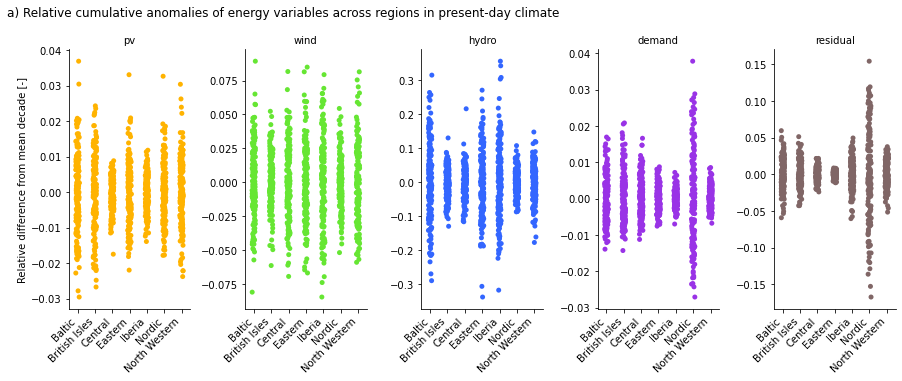

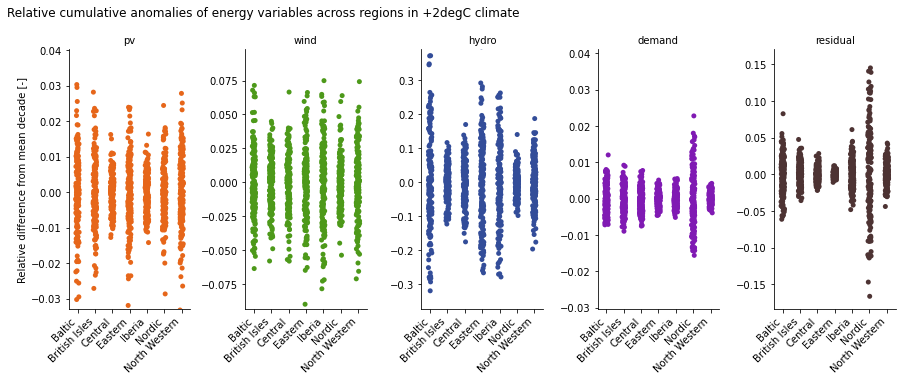

In [48]:
# Define scenarios and their corresponding color dictionaries and titles
scenarios = {
    "PD": {
        "palette": colors_dict_pd,
        "title": "a) Relative cumulative anomalies of energy variables across regions in present-day climate",
        "output_filename": "decadal_scatter_pd.png"
    },
    "FU": {
        "palette": colors_dict_fu,
        "title": "Relative cumulative anomalies of energy variables across regions in +2degC climate",
        "output_filename": "decadal_scatter_fu.png"
    }
}

# Variable to store y-axis limits from the first plot
y_axis_limits = None

# Loop through scenarios and create plots
for i, (scenario, details) in enumerate(scenarios.items()):
    melted_df = melted_results[scenario]  # Use the melted dataframe for the current scenario
    
    # Define the color palette for the current scenario's metrics
    palette = [details["palette"][var] for var in melted_df["var"].unique()]
    
    # Create the catplot
    g = sns.catplot(
        kind="strip",
        data=melted_df,
        x="region",
        y="values",
        hue="var",
        col="var",
        aspect=0.5,
        palette=palette,
        sharey=False
    )
    
    # Remove the "var = " part from the titles
    g.set_titles("{col_name}")
    
    # Rotate the x-axis labels for better readability
    g.set_xticklabels(rotation=45, ha='right')
    
    # Set custom x and y axis labels
    g.set_axis_labels('', 'Relative difference from mean decade [-]')
    
    # Adjust layout to avoid overlapping
    plt.tight_layout()
    
    # Add a main title
    g.fig.suptitle(
        details["title"],
#         y=1.05
        y=1.05, x=0.001, horizontalalignment='left'
    )
    
    # Capture y-axis limits from the first plot
    if i == 0:
        # Extract the y-axis limits from the first plot
        y_axis_limits = [ax.get_ylim() for ax in g.axes.flat]
    else:
        # Apply the y-axis limits from the first plot to subsequent plots
        for ax, limits in zip(g.axes.flat, y_axis_limits):
            ax.set_ylim(limits)
    

    # Save the figure
    plt.savefig(f"{output_dir_img}{details['output_filename']}", dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()


## example of grouped cumulative anomalies and statistical significance

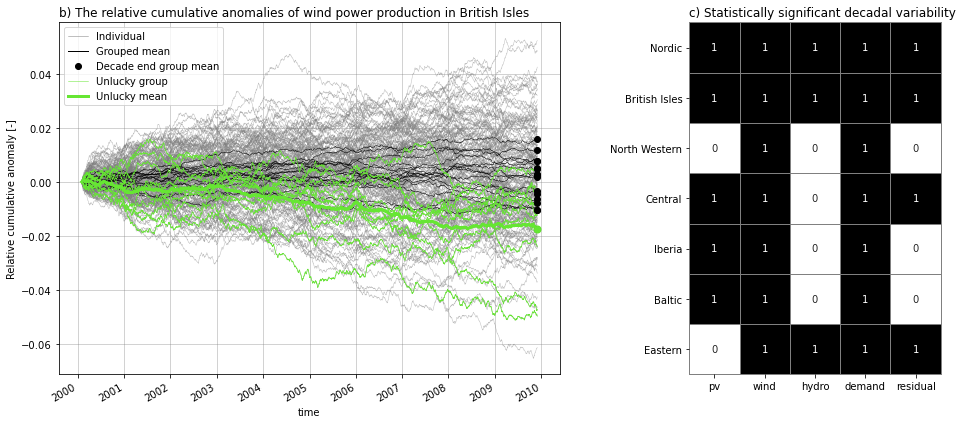

In [33]:
# Data preparation for heatmap
data = (p_values_dict['PD'] < 0.05).astype(int)
index = keys  # Align with the variable `keys` for region names
df = pd.DataFrame(data, index=index)

region = "British Isles"

# Set up subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Line plot on the first subplot (ax1)
dft = normalized_datasets['PD'].wind.sel(region=region).cumsum(dim='time').to_dataframe()[['wind']]
dft = dft.reset_index().pivot(index='time', columns='runs')  # Ensure `runs` column exists
dft.plot(color='grey', linewidth=0.5, legend=False, ax=ax1, alpha=0.5, zorder=0)

runs_per_parent = split_into_chunks(dft.columns, 10)

for r in runs_per_parent[2:3]:
    t = dft.loc[:, r]
    t.plot(color=colors_dict_pd['wind'], ax=ax1, linewidth=0.7, alpha=1, legend=False)
    dft.loc[:, r].mean(axis=1).plot(color=colors_dict_pd['wind'], ax=ax1, linewidth=3, alpha=1, legend=False)
    ax1.scatter(dft.index[-1], dft.loc[:, r].mean(axis=1)[-1], color=colors_dict_pd['wind'], zorder=11, s=50)

for r in runs_per_parent:
    dft.loc[:, r].mean(axis=1).plot(color='black', ax=ax1, linewidth=0.5, zorder=1)
    ax1.scatter(dft.index[-1], dft.loc[:, r].mean(axis=1)[-1], color='black', zorder=10)

# Optional grid settings
ax1.grid(True, which='both', linewidth=0.5, color='grey', alpha=0.7)

# Custom legend items
grey_line = mlines.Line2D([], [], color='grey', linewidth=0.5, label='Individual')
black_line = mlines.Line2D([], [], color='black', linewidth=1, label='Grouped mean')
end_decade_marker = mlines.Line2D([], [], marker='o', color='black', label='Decade end group mean', linestyle='None')
thin_wind_line = mlines.Line2D([], [], color=colors_dict_pd['wind'], linewidth=0.5, label='Unlucky group')
thick_wind_line = mlines.Line2D([], [], color=colors_dict_pd['wind'], linewidth=3, label='Unlucky mean')

# Add the legend to the first plot
ax1.legend(handles=[grey_line, black_line, end_decade_marker, thin_wind_line, thick_wind_line])
ax1.set_ylabel('Relative cumulative anomaly [-]')
ax1.set_title(f'b) The relative cumulative anomalies of wind power production in {region}', loc='left')

# Heatmap on the second subplot (ax2)
sns.heatmap(df, annot=True, cmap='Greys', cbar=False, linewidths=0.5, linecolor='gray', square=True, ax=ax2, clip_on=False)

# Set axis labels and title for heatmap
ax2.set_title("c) Statistically significant decadal variability", loc='left')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig(f"{output_dir_img}decadal_lineplot_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

## Merge into one figure

In [3]:
from PIL import Image

# Open the high-resolution images and convert to RGB mode, filling transparency with white
img1 = Image.open(f"{output_dir_img}decadal_scatter_pd.png").convert("RGB")
img2 = Image.open(f"{output_dir_img}decadal_lineplot_heatmap.png").convert("RGB")

# Calculate the total height for the merged image
total_height = img1.height + img2.height
max_width = max(img1.width, img2.width)

# Create a new blank image with a white background in RGB mode
merged_image = Image.new("RGB", (max_width, total_height), (255, 255, 255))

# Paste the first image at the top
merged_image.paste(img1, (0, 0))

# Paste the second image below the first one
merged_image.paste(img2, (0, img1.height))

# Save the merged image
merged_image.save(f"{output_dir_img}combined_figure_decadal_variability.png", 'PNG')

print("Merged high-resolution image saved as 'combined_figure_decadal_variability.png' with a white background.")


Merged high-resolution image saved as 'combined_figure_decadal_variability.png' with a white background.


## changes in statistical significance decadal variability

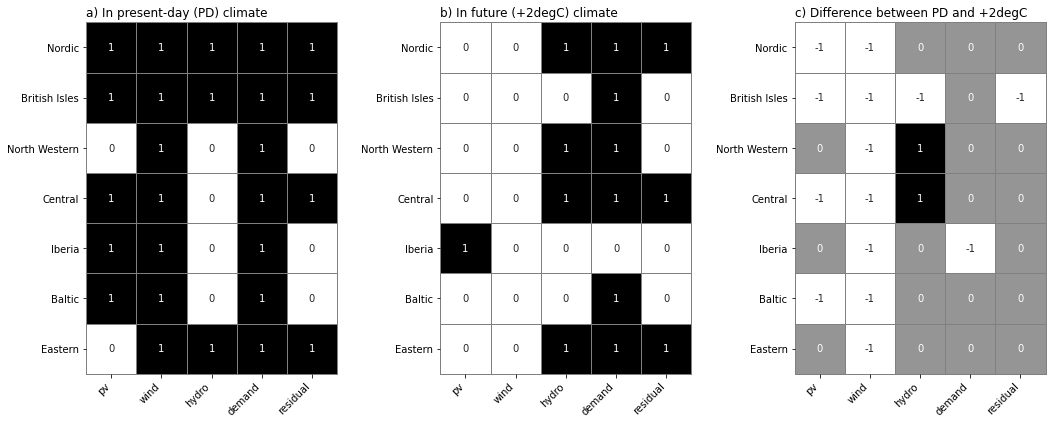

In [10]:
# Data preparation
df_pd = (p_values_dict['PD'] < 0.05).astype(int)  # Present-day climate
df_fu = (p_values_dict['2K'] < 0.05).astype(int)  # Future climate (+2degC)
df_diff = df_fu - df_pd  # Difference between future and present-day

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
ax1, ax2, ax3 = axs

# Heatmaps for each subplot
sns.heatmap(df_pd, annot=True, cmap='Greys', cbar=False, linewidths=0.5, linecolor='gray', square=True, ax=ax1, clip_on=False)
sns.heatmap(df_fu, annot=True, cmap='Greys', cbar=False, linewidths=0.5, linecolor='gray', square=True, ax=ax2, clip_on=False)
sns.heatmap(df_diff, annot=True, cmap='Greys', cbar=False, linewidths=0.5, linecolor='gray', square=True, ax=ax3, clip_on=False)

# Add titles to the subplots
ax1.set_title("a) In present-day (PD) climate", loc='left')
ax2.set_title("b) In future (+2degC) climate", loc='left')
ax3.set_title("c) Difference between PD and +2degC", loc='left')

# Rotate the x-axis tick labels for better readability
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the figure
plt.savefig('climate_change_signal_significance.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# EDW events per runs (decadal veriability of EDW events)

### statistical significance of variance over all runs

In [41]:
def select_energy_vars(ds):
    varsel = ['residual', 'pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand']
    return ds[varsel]

def open_event_df(file, return_period):
    df = pd.read_csv(file, index_col=0)
    df = df.rename({'country': 'region'}, axis=1)
    df['region'] = df['region'].map({k: v for k, v in zip(abr, keys)})
    return df.loc[df.event_nr < ((1600 / return_period) + 1)]

def get_events(ds, df):
    selected_data = []

    # Iterate through events and slice dataset
    for c in df.region.unique():
        country_events = []
        dfc = df.loc[df.region == c]
        
        for _, event in dfc.iterrows():
            data_slice = ds.sel(runs=event['runs'], region=event['region'], time=slice(event['ts0'], event['tsn']))
            country_events.append(data_slice)

        selected_data.append(xr.concat(country_events, dim='event'))

    # Concatenate data across regions and add event numbers
    ds = xr.concat(selected_data, dim='region')
    ds['event'] = np.arange(1, len(ds.event) + 1)
    return ds


def select_energy_vars(ds):
    varsel = ['residual', 'pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand']
    return ds[varsel]
    
# Count the number of event days per run in the dataset
def count_event_days(dsevents, variable, region=None):
    if region:
        dsevents = dsevents.sel(region=region, drop=True)  # Select specific region
    
    # Count non-NaN values (indicating event days) per event and region
    event_days = dsevents[variable].notnull().sum(dim='time')
    return event_days

# Extend DataFrame to include all runs with zero events if missing
def ensure_all_runs_present(df, all_runs):
    df = df.reindex(all_runs, fill_value=0)  # Reindex to include all runs, fill missing with 0
    return df

# Event length for filtering
event_length = 7

return_period = 10
# Process events for each season
for season in ['DJF']:#, 'MAM', 'JJA', 'SON']:
    # File paths for PD and FU scenarios
    file_pd = f'residual_el{event_length}_{season}_PD_project3.csv'
    file_fu = f'residual_el{event_length}_{season}_FU_project3.csv'
    
    # Process PD events
    df_pd = open_event_df(file_pd, return_period)  # Load event data for PD
    dsevents_pd = get_events(ds_results['PD'], df_pd)  # Select events matching criteria
    dsevents_pd = select_energy_vars(dsevents_pd)  # Select relevant energy variables
 
    # Process FU events
    df_fu = open_event_df(file_fu, return_period)  # Load event data for FU
    dsevents_fu = get_events(ds_results['FU'], df_fu)  # Select events matching criteria
    dsevents_fu = select_energy_vars(dsevents_fu)  # Select relevant energy variables

# ---------------------
### GROUPED PER RUN
# ---------------------

# List of all runs
all_runs_pd = ds_results['PD'].runs.values
all_runs_fu = ds_results['FU'].runs.values

# Scenarios and their configurations
scenarios = {
    "PD": {
        "dsevents": dsevents_pd,
        "all_runs": all_runs_pd
    },
    "FU": {
        "dsevents": dsevents_fu,
        "all_runs": all_runs_fu
    }
}

# Initialize the dictionary to store p-values
p_values_event7_dict = {}

# Parameters for bootstrap test
n_runs = 160
n_bootstraps = 10000
n_events = (1600 / return_period)

# Loop over scenarios
for scenario, config in scenarios.items():
    # Initialize DataFrame to store p-values for each region
    df_with_p_values = pd.DataFrame(index=keys, columns=["p_value"])
    
    for region in keys:
        # Process the scenario for the given region
        event_days = count_event_days(config["dsevents"], variable='residual', region=region)
        dft = event_days.to_dataframe(name='event_days')

        # Calculate the number of events per run
        events_per_run = dft.groupby('runs').sum() / event_length

        # Ensure all runs are included
        events_per_run = ensure_all_runs_present(events_per_run, config["all_runs"])

        # Bootstrap Test
        bootstrap_results = []
        observed_variance = float(events_per_run.var())  # Observed variance for this region

        for _ in range(n_bootstraps):
            bootstrap_sample = np.random.multinomial(n_events, [1 / n_runs] * n_runs)
            bootstrap_results.append(np.var(bootstrap_sample))

        # Convert bootstrap results to array
        bootstrap_results = np.array(bootstrap_results)

        # Compute p-value
        p_value = np.mean(bootstrap_results >= observed_variance)
        df_with_p_values.loc[region, "p_value"] = p_value

    # Store the p-values DataFrame in the dictionary
    p_values_event7_dict[scenario] = df_with_p_values

# Print the resulting p-values for both scenarios
for scenario, df in p_values_event_dict.items():
    print(f"P-values for {scenario} scenario:")
    print(df)

# Split runs into groups of a specified size
def split_into_chunks(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

# List of regions
keys = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia', 'Baltic', 'Eastern']

# Initialize the dictionary to store p-values
p_values_event7_grouped_dict = {}

# Loop over scenarios
for scenario, config in scenarios.items():
    # Initialize DataFrame to store p-values for each region
    df_with_p_values_grouped = pd.DataFrame(index=keys, columns=["p_value"])

    for region in keys:
        # Process the scenario for the given region
        event_days = count_event_days(config["dsevents"], variable='residual', region=region)
        dft = event_days.to_dataframe(name='event_days')

        # Calculate the number of events per run
        events_per_run = dft.groupby('runs').sum() / event_length

        # Ensure all runs are included
        events_per_run = ensure_all_runs_present(events_per_run, config["all_runs"])

        # Convert events_per_run to a NumPy array for faster operations
        events_per_run_array = events_per_run['event_days'].values

        # Group runs by parent once
        runs_per_parent = split_into_chunks(range(len(events_per_run_array)), 10)
        parent_means = np.array([events_per_run_array[runs].mean() for runs in runs_per_parent])

        # Calculate observed variance of subset means
        observed_variance = np.var(parent_means, ddof=1)

        # Bootstrap Test
        n_iterations = 1000
        bootstrap_variances = []

        for _ in range(n_iterations):
            # Resample data with replacement
            boot_sample = resample(events_per_run_array, n_samples=len(events_per_run_array), replace=True)

            # Calculate means for parent groups in the resampled data
            boot_parent_means = np.array([boot_sample[runs].mean() for runs in runs_per_parent])

            # Calculate variance of subset means
            boot_var = np.var(boot_parent_means, ddof=1)
            bootstrap_variances.append(boot_var)

        # Convert bootstrap variances to array
        bootstrap_variances = np.array(bootstrap_variances)

        # Compute p-value
        p_value_grouped = np.mean(bootstrap_variances >= observed_variance)
        df_with_p_values_grouped.loc[region, "p_value"] = p_value_grouped

    # Store the p-values DataFrame in the dictionary
    p_values_event7_grouped_dict[scenario] = df_with_p_values_grouped

# Print the resulting grouped p-values for both scenarios
for scenario, df in p_values_event_grouped_dict.items():
    print(f"Grouped P-values for {scenario} scenario:")
    print(df)

P-values for PD scenario:
              p_value
Nordic            0.0
British Isles  0.4326
North Western  0.3889
Central        0.0263
Iberia         0.0004
Baltic            0.0
Eastern        0.0072
P-values for FU scenario:
              p_value
Nordic            0.0
British Isles  0.2415
North Western  0.2134
Central        0.0944
Iberia         0.0815
Baltic            0.0
Eastern          0.01
Grouped P-values for PD scenario:
              p_value
Nordic           0.08
British Isles   0.029
North Western   0.524
Central         0.076
Iberia          0.441
Baltic          0.125
Eastern         0.333
Grouped P-values for FU scenario:
              p_value
Nordic          0.419
British Isles   0.565
North Western   0.437
Central         0.424
Iberia          0.377
Baltic          0.277
Eastern         0.192


In [43]:
# event length 3

In [44]:
# Event length for filtering
event_length = 30

return_period = 10
# Process events for each season
for season in ['DJF']:#, 'MAM', 'JJA', 'SON']:
    # File paths for PD and FU scenarios
    file_pd = f'residual_el{event_length}_{season}_PD_project3.csv'
    file_fu = f'residual_el{event_length}_{season}_FU_project3.csv'
    
    # Process PD events
    df_pd = open_event_df(file_pd, return_period)  # Load event data for PD
    dsevents_pd = get_events(ds_results['PD'], df_pd)  # Select events matching criteria
    dsevents_pd = select_energy_vars(dsevents_pd)  # Select relevant energy variables
 
    # Process FU events
    df_fu = open_event_df(file_fu, return_period)  # Load event data for FU
    dsevents_fu = get_events(ds_results['FU'], df_fu)  # Select events matching criteria
    dsevents_fu = select_energy_vars(dsevents_fu)  # Select relevant energy variables


# List of all runs
all_runs_pd = ds_results['PD'].runs.values
all_runs_fu = ds_results['FU'].runs.values

# Scenarios and their configurations
scenarios = {
    "PD": {
        "dsevents": dsevents_pd,
        "all_runs": all_runs_pd
    },
    "FU": {
        "dsevents": dsevents_fu,
        "all_runs": all_runs_fu
    }
}

# Initialize the dictionary to store p-values
p_values_event30_dict = {}

# Parameters for bootstrap test
n_runs = 160
n_bootstraps = 10000
n_events = (1600 / return_period)

# Loop over scenarios
for scenario, config in scenarios.items():
    # Initialize DataFrame to store p-values for each region
    df_with_p_values = pd.DataFrame(index=keys, columns=["p_value"])
    
    for region in keys:
        # Process the scenario for the given region
        event_days = count_event_days(config["dsevents"], variable='residual', region=region)
        dft = event_days.to_dataframe(name='event_days')

        # Calculate the number of events per run
        events_per_run = dft.groupby('runs').sum() / event_length

        # Ensure all runs are included
        events_per_run = ensure_all_runs_present(events_per_run, config["all_runs"])

        # Bootstrap Test
        bootstrap_results = []
        observed_variance = float(events_per_run.var())  # Observed variance for this region

        for _ in range(n_bootstraps):
            bootstrap_sample = np.random.multinomial(n_events, [1 / n_runs] * n_runs)
            bootstrap_results.append(np.var(bootstrap_sample))

        # Convert bootstrap results to array
        bootstrap_results = np.array(bootstrap_results)

        # Compute p-value
        p_value = np.mean(bootstrap_results >= observed_variance)
        df_with_p_values.loc[region, "p_value"] = p_value

    # Store the p-values DataFrame in the dictionary
    p_values_event30_dict[scenario] = df_with_p_values

# Print the resulting p-values for both scenarios
for scenario, df in p_values_event_dict.items():
    print(f"P-values for {scenario} scenario:")
    print(df)

# Split runs into groups of a specified size
def split_into_chunks(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

# List of regions
keys = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia', 'Baltic', 'Eastern']

# Initialize the dictionary to store p-values
p_values_event30_grouped_dict = {}

# Loop over scenarios
for scenario, config in scenarios.items():
    # Initialize DataFrame to store p-values for each region
    df_with_p_values_grouped = pd.DataFrame(index=keys, columns=["p_value"])

    for region in keys:
        # Process the scenario for the given region
        event_days = count_event_days(config["dsevents"], variable='residual', region=region)
        dft = event_days.to_dataframe(name='event_days')

        # Calculate the number of events per run
        events_per_run = dft.groupby('runs').sum() / event_length

        # Ensure all runs are included
        events_per_run = ensure_all_runs_present(events_per_run, config["all_runs"])

        # Convert events_per_run to a NumPy array for faster operations
        events_per_run_array = events_per_run['event_days'].values

        # Group runs by parent once
        runs_per_parent = split_into_chunks(range(len(events_per_run_array)), 10)
        parent_means = np.array([events_per_run_array[runs].mean() for runs in runs_per_parent])

        # Calculate observed variance of subset means
        observed_variance = np.var(parent_means, ddof=1)

        # Bootstrap Test
        n_iterations = 1000
        bootstrap_variances = []

        for _ in range(n_iterations):
            # Resample data with replacement
            boot_sample = resample(events_per_run_array, n_samples=len(events_per_run_array), replace=True)

            # Calculate means for parent groups in the resampled data
            boot_parent_means = np.array([boot_sample[runs].mean() for runs in runs_per_parent])

            # Calculate variance of subset means
            boot_var = np.var(boot_parent_means, ddof=1)
            bootstrap_variances.append(boot_var)

        # Convert bootstrap variances to array
        bootstrap_variances = np.array(bootstrap_variances)

        # Compute p-value
        p_value_grouped = np.mean(bootstrap_variances >= observed_variance)
        df_with_p_values_grouped.loc[region, "p_value"] = p_value_grouped

    # Store the p-values DataFrame in the dictionary
    p_values_event30_grouped_dict[scenario] = df_with_p_values_grouped

# Print the resulting grouped p-values for both scenarios
for scenario, df in p_values_event_grouped_dict.items():
    print(f"Grouped P-values for {scenario} scenario:")
    print(df)

P-values for PD scenario:
              p_value
Nordic            0.0
British Isles  0.4326
North Western  0.3889
Central        0.0263
Iberia         0.0004
Baltic            0.0
Eastern        0.0072
P-values for FU scenario:
              p_value
Nordic            0.0
British Isles  0.2415
North Western  0.2134
Central        0.0944
Iberia         0.0815
Baltic            0.0
Eastern          0.01
Grouped P-values for PD scenario:
              p_value
Nordic           0.08
British Isles   0.029
North Western   0.524
Central         0.076
Iberia          0.441
Baltic          0.125
Eastern         0.333
Grouped P-values for FU scenario:
              p_value
Nordic          0.419
British Isles   0.565
North Western   0.437
Central         0.424
Iberia          0.377
Baltic          0.277
Eastern         0.192


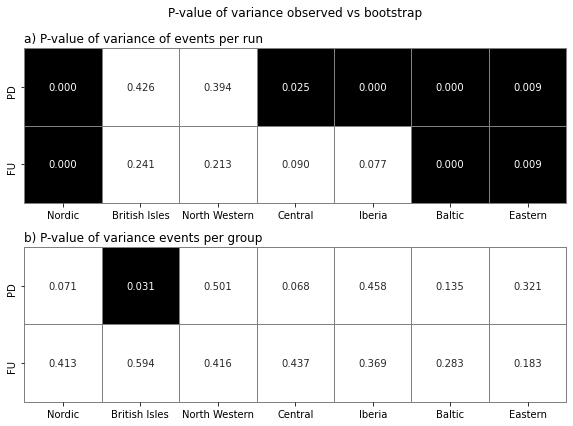

In [45]:
from matplotlib.colors import BoundaryNorm, ListedColormap

# Combine DataFrames into a single DataFrame
heatmap_df_runs = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_event7_dict.items()}, 
    axis=1
).astype(float)
heatmap_df_grouped = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_event7_grouped_dict.items()}, 
    axis=1
).astype(float)

# set binary colormap
my_colors = ['black', 'white']
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.05, 1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))


# Plot the heatmap
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
ax1, ax2  = axs

fig.suptitle('P-value of variance observed vs bootstrap')

sns.heatmap(
    heatmap_df_runs.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax1, clip_on=False# Font size for annotations
)

sns.heatmap(
    heatmap_df_grouped.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax2, clip_on=False# Font size for annotations
)

# Add titles to the subplots
ax1.set_title("a) P-value of variance of events per run", loc='left')
ax2.set_title("b) P-value of variance events per group", loc='left')

plt.tight_layout()
# Add labels and title
# plt.xlabel("Scenario")
# plt.ylabel("Region")
plt.show()

# just extremes values, not energy droughts

In [24]:
import pandas as pd
import numpy as np
import xarray as xr

# List of regions and scenarios
regions = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia', 'Baltic', 'Eastern']
scenarios = ['PD', 'FU']

# Dictionary to store p-values
p_values_extreme_dict = {}

# Parameters
n_runs = 160
n_bootstraps = 1000

# Loop over scenarios
for scenario in scenarios:
    # Initialize DataFrame to store p-values for each region in the scenario
    df_with_p_values = pd.DataFrame(index=regions, columns=["p_value"])
    
    for region in regions:
        # Select data for the region and scenario
        dst = anomaly_results[scenario][['residual']].sel(region=region, drop=True)
        testthis = dst.where(dst > dst.quantile(0.99))
        
        # Count the number of times this happens per run
        times = xr.where(testthis > 1, 1, 0).sum(dim='time')
        
        # Convert to DataFrame
        dft = times.to_dataframe()
        
        # Extract numeric part of the index and group by chunks of 10
        dft['group'] = (dft.index.str.extract(r'(\d+)$').astype(int) // 10).values
        
        # Group by 'group' and calculate the mean
        grouped_means = dft.groupby('group').sum()
        
        # Total days to distribute
        total_days = dft['residual'].sum()
        
        # Observed distribution
        observed_residual = dft['residual'].values
        
        # Perform bootstrap sampling
        bootstrap_distributions = []
        for _ in range(n_bootstraps):
            random_distribution = np.random.multinomial(total_days, [1 / n_runs] * n_runs)
            bootstrap_distributions.append(random_distribution)
        
        # Convert bootstrap results to a NumPy array
        bootstrap_distributions = np.array(bootstrap_distributions)
        
        # Test statistic: Variance of the distribution
        observed_stat = np.var(observed_residual)
        bootstrap_stats = np.var(bootstrap_distributions, axis=1)
        
        # Compute p-value
        p_value = np.mean(bootstrap_stats >= observed_stat)
        
        # Store p-value in the DataFrame
        df_with_p_values.loc[region, "p_value"] = p_value

    # Store the p-values DataFrame in the dictionary
    p_values_extreme_dict[scenario] = df_with_p_values

# Print the resulting grouped p-values for both scenarios
for scenario, df in p_values_extreme_dict.items():
    print(f"Grouped P-values for {scenario} scenario:")
    print(df)

Grouped P-values for PD scenario:
              p_value
Nordic            0.0
British Isles     0.0
North Western     0.0
Central           0.0
Iberia            0.0
Baltic            0.0
Eastern           0.0
Grouped P-values for FU scenario:
              p_value
Nordic            0.0
British Isles     0.0
North Western     0.0
Central           0.0
Iberia            0.0
Baltic            0.0
Eastern           0.0


In [25]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Utility function to split runs into groups
def split_into_chunks(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

# List of regions and scenarios
regions = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia', 'Baltic', 'Eastern']
scenarios = ['PD', 'FU']

# Dictionary to store p-values for grouped variance
p_values_extreme_grouped_dict = {}

# Parameters
n_runs = 160
n_bootstraps = 1000
group_size = 10  # Size of each group

# Loop over scenarios
for scenario in scenarios:
    # Initialize DataFrame to store p-values for each region in the scenario
    df_with_p_values_grouped = pd.DataFrame(index=regions, columns=["p_value"])
    
    for region in regions:
        # Select data for the region and scenario
        dst = anomaly_results[scenario][['residual']].sel(region=region, drop=True)
        testthis = dst.where(dst > dst.quantile(0.99))
        
        # Count the number of times this happens per run
        times = xr.where(testthis > 1, 1, 0).sum(dim='time')
        
        # Convert to DataFrame
        dft = times.to_dataframe()
        
        # Ensure all runs are included
        all_runs = dst.runs.values
        dft = dft.reindex(all_runs, fill_value=0)
        
        # Group runs into parents
        runs_per_parent = split_into_chunks(dft.index, group_size)
        parent_means = np.array([dft.loc[runs, 'residual'].mean() for runs in runs_per_parent])

        # Calculate observed variance of subset means
        observed_variance = np.var(parent_means, ddof=1)

        # Bootstrap Test
        bootstrap_variances = []
        for _ in range(n_bootstraps):
            # Resample data with replacement
            boot_sample = resample(dft['residual'].values, n_samples=n_runs, replace=True)
            
            runs_per_parent_idx = split_into_chunks(np.arange(n_runs), group_size)
            # Calculate means for parent groups in the resampled data
            boot_parent_means = np.array([boot_sample[runs].mean() for runs in runs_per_parent_idx])
            
            # Calculate variance of subset means
            boot_var = np.var(boot_parent_means, ddof=1)
            bootstrap_variances.append(boot_var)
        
        # Convert bootstrap variances to array
        bootstrap_variances = np.array(bootstrap_variances)

        # Compute p-value
        p_value_grouped = np.mean(bootstrap_variances >= observed_variance)
        df_with_p_values_grouped.loc[region, "p_value"] = p_value_grouped

    # Store the p-values DataFrame in the dictionary
    p_values_extreme_grouped_dict[scenario] = df_with_p_values_grouped

# Print the resulting grouped p-values for both scenarios
for scenario, df in p_values_extreme_grouped_dict.items():
    print(f"Grouped P-values for {scenario} scenario:")
    print(df)


Grouped P-values for PD scenario:
              p_value
Nordic          0.002
British Isles   0.001
North Western   0.004
Central           0.0
Iberia           0.03
Baltic            0.0
Eastern         0.001
Grouped P-values for FU scenario:
              p_value
Nordic          0.267
British Isles   0.003
North Western   0.336
Central         0.326
Iberia          0.053
Baltic            0.0
Eastern          0.73


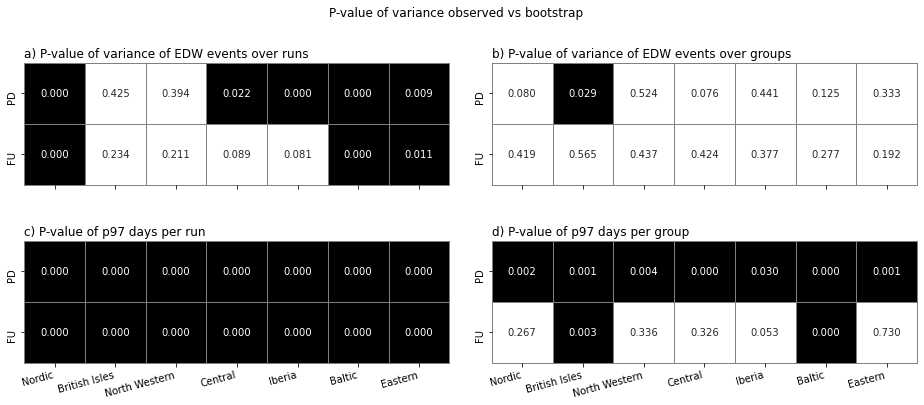

In [26]:
from matplotlib.colors import BoundaryNorm, ListedColormap

# Combine DataFrames into a single DataFrame
heatmap_df_runs = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_event_dict.items()}, 
    axis=1
).astype(float)
heatmap_df_grouped = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_event_grouped_dict.items()}, 
    axis=1
).astype(float)

# Combine DataFrames into a single DataFrame
heatmap_df_runs_extreme = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_extreme_dict.items()}, 
    axis=1
).astype(float)
heatmap_df_grouped_extreme = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_extreme_grouped_dict.items()}, 
    axis=1
).astype(float)

# set binary colormap
my_colors = ['black', 'white']
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.05, 1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))


# Plot the heatmap
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
(ax1, ax3), (ax2, ax4)  = axs

fig.suptitle('P-value of variance observed vs bootstrap')

# Increase spacing
fig.subplots_adjust(hspace=0.5, wspace=0.3)

sns.heatmap(
    heatmap_df_runs.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax1, clip_on=False# Font size for annotations
)

sns.heatmap(
    heatmap_df_grouped.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax3, clip_on=False# Font size for annotations
)

sns.heatmap(
    heatmap_df_runs_extreme.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax2, clip_on=False# Font size for annotations
)

sns.heatmap(
    heatmap_df_grouped_extreme.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax4, clip_on=False# Font size for annotations
)


# Add titles to the subplots
ax1.set_title("a) P-value of variance of EDW events over runs", loc='left')
ax3.set_title("b) P-value of variance of EDW events over groups", loc='left')

ax2.set_title("c) P-value of p97 days per run", loc='left')
ax4.set_title("d) P-value of p97 days per group", loc='left')

# Remove x-axis labels for the top plots
ax1.tick_params(axis='x', labelbottom=False)
ax3.tick_params(axis='x', labelbottom=False)

# Rotate the x-axis tick labels for better readability
for ax in [ax2, ax4]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

    # Increase spacing
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# plt.tight_layout()
# Add labels and title
# plt.xlabel("Scenario")
# plt.ylabel("Region")
plt.show()


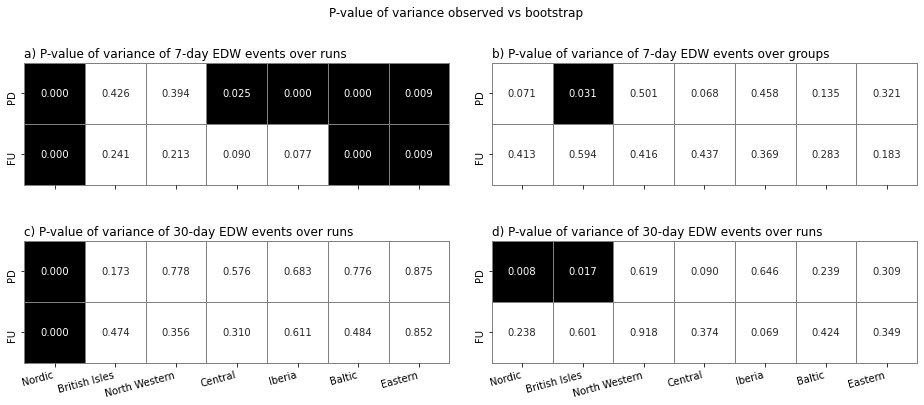

In [49]:
from matplotlib.colors import BoundaryNorm, ListedColormap

# Combine DataFrames into a single DataFrame
heatmap_df_runs = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_event7_dict.items()}, 
    axis=1
).astype(float)
heatmap_df_grouped = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_event7_grouped_dict.items()}, 
    axis=1
).astype(float)

# Combine DataFrames into a single DataFrame
heatmap_df_runs_extreme = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_event30_dict.items()}, 
    axis=1
).astype(float)
heatmap_df_grouped_extreme = pd.concat(
    {scenario: df['p_value'] for scenario, df in p_values_event30_grouped_dict.items()}, 
    axis=1
).astype(float)

# set binary colormap
my_colors = ['black', 'white']
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.05, 1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))


# Plot the heatmap
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
(ax1, ax3), (ax2, ax4)  = axs

fig.suptitle('P-value of variance observed vs bootstrap')

# Increase spacing
fig.subplots_adjust(hspace=0.5, wspace=0.3)

sns.heatmap(
    heatmap_df_runs.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax1, clip_on=False# Font size for annotations
)

sns.heatmap(
    heatmap_df_grouped.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax3, clip_on=False# Font size for annotations
)

sns.heatmap(
    heatmap_df_runs_extreme.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax2, clip_on=False# Font size for annotations
)

sns.heatmap(
    heatmap_df_grouped_extreme.T,
    annot=True,
    fmt=".3f",
    cmap=my_cmap,  # Black and white colormap
    norm = my_norm,
    cbar=False,
    linewidths=0.5,
    annot_kws={"fontsize": 10},  linecolor='gray', square=True, ax =ax4, clip_on=False# Font size for annotations
)


# Add titles to the subplots
ax1.set_title("a) P-value of variance of 7-day EDW events over runs", loc='left')
ax3.set_title("b) P-value of variance of 7-day EDW events over groups", loc='left')

ax2.set_title("c) P-value of variance of 30-day EDW events over runs", loc='left')
ax4.set_title("d) P-value of variance of 30-day EDW events over runs", loc='left')

# Remove x-axis labels for the top plots
ax1.tick_params(axis='x', labelbottom=False)
ax3.tick_params(axis='x', labelbottom=False)

# Rotate the x-axis tick labels for better readability
for ax in [ax2, ax4]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')

    # Increase spacing
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# Save the figure
plt.savefig('decadal_significance_30_and_7_day_events.png', dpi=300, bbox_inches='tight')

# plt.tight_layout()
# Add labels and title
# plt.xlabel("Scenario")
# plt.ylabel("Region")
plt.show()
